###  途中からニューロンの数が変わるモデル
DropOutの理論を転用して、初めは使うニューロンの数を制限する。<br>
一定数エポックが経ったら、使っていなかったニューロンを開放してあげる。<br>

一番単純なモデル


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



In [2]:
config={
    'BatchSize':128,
    'seed':42,
    'n_epochs' : 100,
    'lr' : 0.0001
}

In [12]:

trainval_dataset = datasets.CIFAR10('../data/cifar10', train=True,download=True,transform=transforms.ToTensor())

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor()])

trainval_dataset = datasets.CIFAR10('../data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000],generator=torch.Generator().manual_seed(config['seed']))

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['BatchSize'],
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['BatchSize'],
    shuffle=True
)

print("Train data number:{}, Valid data number: {}".format(len(train_dataset), len(val_dataset)))

Files already downloaded and verified
Train data number:40000, Valid data number: 10000


In [13]:
class Bio_genesis(nn.Module):
    def __init__(self,ratio=0.5):
        super().__init__()
        self.ratio=ratio
        self.Mask=True
    
    def forward(self,x):
        if self.training:
            if epoch <30:
                self.mask=torch.rand(*x.size()) > self.ratio
                return x * self.mask.to(x.device)
                
            else:
                
                return  x * (1.0 - self.ratio)
        else:
            return x

In [14]:

class NeurogenesisModel(nn.Module):
    def __init__(self):
        super(NeurogenesisModel, self).__init__()
        self.conv1=nn.Conv2d(3, 32, 3)       # 32x32x3 -> 30x30x32
        self.bn1=nn.BatchNorm2d(32)
        self.av1=nn.ReLU()
        self.pool1=nn.AvgPool2d(2)                  # 30x30x32 -> 15x15x32
        self.conv2=nn.Conv2d(32, 64, 3)             # 15x15x32 -> 13x13x64
        self.bn2=nn.BatchNorm2d(64)
        self.av2=nn.ReLU()
        self.pool2=nn.AvgPool2d(2)                  # 13x13x64 -> 6x6x64
        self.conv3=nn.Conv2d(64, 128, 3)            # 6x6x64 -> 4x4x128
        self.bn3=nn.BatchNorm2d(128)
        self.av3=nn.ReLU()
        self.pool3=nn.AvgPool2d(2)                  # 4x4x128 -> 2x2x128
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(2*2*128, 256)
        self.relu=nn.ReLU()
        self.genesis=Bio_genesis()
        self.fc2=nn.Linear(256, 10)
        #self.fc1 = nn.Linear(input_size, hidden_size)
        #self.relu = nn.ReLU()
        #self.fc2 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.av1(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.av2(x)
        x=self.pool2(x)     
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.av3(x)
        x=self.pool3(x)  
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.genesis(x)
        x=self.fc2(x)
        return x

model=NeurogenesisModel()

In [15]:

def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

model.apply(init_weights)

device='cuda'
model.to(device)
optimizer2 = optim.Adam(model.parameters(), lr=config['lr'])
loss_function = nn.CrossEntropyLoss() 

EPOCH: 1, Train [Loss: 1.928, Accuracy: 0.298], Valid [Loss: 1.601, Accuracy: 0.437]]
EPOCH: 2, Train [Loss: 1.593, Accuracy: 0.420], Valid [Loss: 1.439, Accuracy: 0.507]]
EPOCH: 3, Train [Loss: 1.442, Accuracy: 0.481], Valid [Loss: 1.361, Accuracy: 0.543]]
EPOCH: 4, Train [Loss: 1.336, Accuracy: 0.523], Valid [Loss: 1.303, Accuracy: 0.575]]
EPOCH: 5, Train [Loss: 1.256, Accuracy: 0.555], Valid [Loss: 1.242, Accuracy: 0.592]]
EPOCH: 6, Train [Loss: 1.195, Accuracy: 0.576], Valid [Loss: 1.213, Accuracy: 0.610]]
EPOCH: 7, Train [Loss: 1.146, Accuracy: 0.596], Valid [Loss: 1.192, Accuracy: 0.624]]
EPOCH: 8, Train [Loss: 1.102, Accuracy: 0.610], Valid [Loss: 1.162, Accuracy: 0.641]]
EPOCH: 9, Train [Loss: 1.065, Accuracy: 0.626], Valid [Loss: 1.147, Accuracy: 0.649]]
EPOCH: 10, Train [Loss: 1.036, Accuracy: 0.636], Valid [Loss: 1.116, Accuracy: 0.659]]
EPOCH: 11, Train [Loss: 1.006, Accuracy: 0.648], Valid [Loss: 1.100, Accuracy: 0.665]]
EPOCH: 12, Train [Loss: 0.980, Accuracy: 0.657], Val

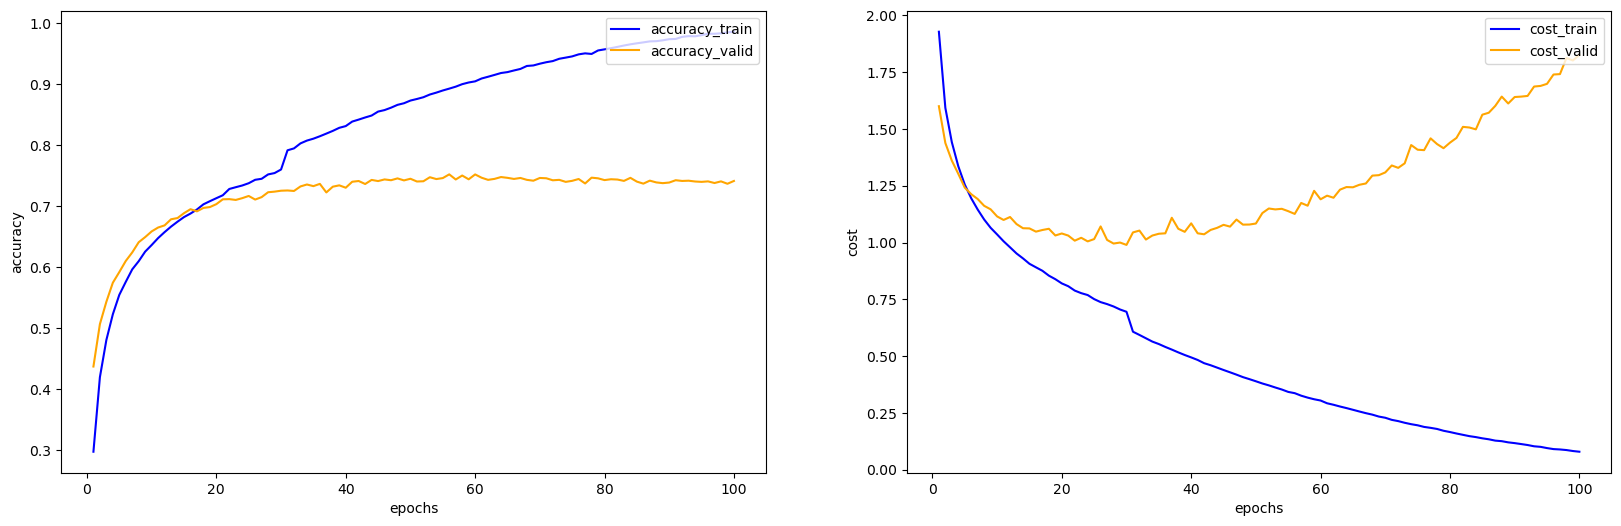

In [16]:
accuracy_train=[]
cost_train=[]
accuracy_valid=[]
cost_valid=[]

for epoch in range(config['n_epochs']):
    losses_train = []
    losses_valid = []

    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        model.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = model.forward(x)  # 順伝播


        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer2.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    accuracy_train.append(acc_train/n_train)
    cost_train.append(np.mean(losses_train))

    model.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = model.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    accuracy_valid.append(acc_val/n_val)
    cost_valid.append(np.mean(losses_valid))

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]]'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val,
    ))


x=np.arange(1,config['n_epochs']+1,1)
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')

plt.show()

In [32]:
import numpy as np

def save_weights(model, filename):
    weights = {}

    # モデルの各層の名前とパラメータを取得
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights[name] = param.detach().cpu().numpy()

    # .npz ファイルとして出力
    np.savez(filename, **weights)

save_weights(model, 'weights.npz')
data = np.load('weights.npz')

for key in data.keys():
    print(key, data[key].shape)

conv1.weight (32, 3, 3, 3)
bn1.weight (32,)
conv2.weight (64, 32, 3, 3)
bn2.weight (64,)
conv3.weight (128, 64, 3, 3)
bn3.weight (128,)
fc1.weight (256, 512)
fc2.weight (10, 256)


In [33]:
conv_net2 = nn.Sequential(
    nn.Conv2d(3, 32, 3),              # 32x32x3 -> 30x30x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 30x30x32 -> 15x15x32
    nn.Conv2d(32, 64, 3),             # 15x15x32 -> 13x13x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 13x13x64 -> 6x6x64
    nn.Conv2d(64, 128, 3),            # 6x6x64 -> 4x4x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 4x4x128 -> 2x2x128
    nn.Flatten(),
    nn.Linear(2*2*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net2.apply(init_weights)

batch_size = 100
n_epochs = 5
lr = 0.01
device = 'cuda'

conv_net2.to(device)
optimizer2 = optim.Adam(conv_net2.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()  # nn.ClossEntropyLossは，出力のsoftmax変換と，正解ラベルのone-hot vector化の機能を持っている

EPOCH: 1, Train [Loss: 1.497, Accuracy: 0.462], Valid [Loss: 1.325, Accuracy: 0.528]]
EPOCH: 2, Train [Loss: 1.038, Accuracy: 0.632], Valid [Loss: 1.235, Accuracy: 0.587]]
EPOCH: 3, Train [Loss: 0.860, Accuracy: 0.696], Valid [Loss: 0.963, Accuracy: 0.663]]
EPOCH: 4, Train [Loss: 0.737, Accuracy: 0.744], Valid [Loss: 1.014, Accuracy: 0.650]]
EPOCH: 5, Train [Loss: 0.650, Accuracy: 0.773], Valid [Loss: 0.827, Accuracy: 0.717]]
EPOCH: 6, Train [Loss: 0.586, Accuracy: 0.795], Valid [Loss: 0.946, Accuracy: 0.681]]
EPOCH: 7, Train [Loss: 0.528, Accuracy: 0.817], Valid [Loss: 1.541, Accuracy: 0.586]]
EPOCH: 8, Train [Loss: 0.477, Accuracy: 0.835], Valid [Loss: 0.843, Accuracy: 0.724]]
EPOCH: 9, Train [Loss: 0.425, Accuracy: 0.850], Valid [Loss: 1.065, Accuracy: 0.673]]
EPOCH: 10, Train [Loss: 0.393, Accuracy: 0.863], Valid [Loss: 1.505, Accuracy: 0.612]]
EPOCH: 11, Train [Loss: 0.351, Accuracy: 0.877], Valid [Loss: 1.007, Accuracy: 0.710]]
EPOCH: 12, Train [Loss: 0.316, Accuracy: 0.890], Val

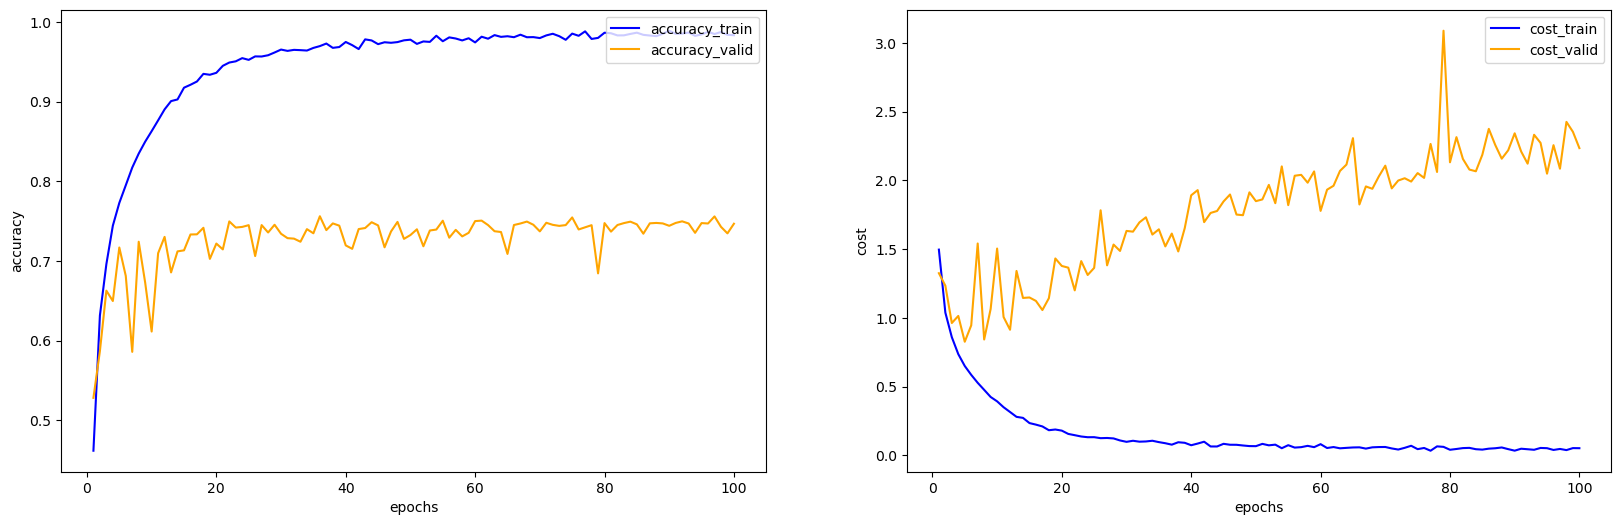

In [34]:
accuracy_train=[]
cost_train=[]
accuracy_valid=[]
cost_valid=[]

for epoch in range(config['n_epochs']):
    losses_train = []
    losses_valid = []

    conv_net2.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net2.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播


        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer2.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    accuracy_train.append(acc_train/n_train)
    cost_train.append(np.mean(losses_train))

    conv_net2.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    accuracy_valid.append(acc_val/n_val)
    cost_valid.append(np.mean(losses_valid))

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]]'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val,
    ))


x=np.arange(1,config['n_epochs']+1,1)
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')

plt.show()

In [17]:
import torchvision
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor() )
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

correct = 0
total = 0
# 勾配を記憶せず（学習せずに）に計算を行う
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 74 %


In [36]:
import torchvision
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor() )
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

correct = 0
total = 0
# 勾配を記憶せず（学習せずに）に計算を行う
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = conv_net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 73 %
